In [163]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
import os
import sys
import logging

import requests
from tqdm import tqdm_notebook
tqdm = tqdm_notebook

import numpy as np
import pandas as pd

from dvidutils import LabelMapper
from libdvid import DVIDNodeService

from neuclease import configure_default_logging
from neuclease.util.util import drop_unordered_duplicates
from neuclease.dvid import *
from neuclease.focused.ingest import fetch_focused_decisions, drop_previously_reviewed, load_focused_table
from neuclease.merge_table import (normalize_recarray_inplace, load_all_supervoxel_sizes, compute_body_sizes,
                                   generate_focused_assignment, generate_assignments)
from neuclease.merge_graph import LabelmapMergeGraph

In [123]:
from neuclease.dvid.labelmap._split import *
from neuclease.dvid.labelmap._labelmap import *

In [4]:
configure_default_logging()

In [5]:
pwd

'/nrs/flyem/bergs/complete-ffn-agglo'

### UUIDs

In [93]:
server = 'emdata3:8900'
analysis_node = (server, '662e')
analysis_seg = analysis_node + ('segmentation',)

master_uuid = find_branch_nodes(server, 'a77', branch="")[-1]
master_node = (server, master_uuid)
master_seg = master_node + ('segmentation',)
print(f"Working with current master UUID: {master_uuid}")

Working with current master UUID: 07160ccb9ee849ad8465c3b617bb90e5


### Mapping

In [9]:
analysis_mapping = fetch_complete_mappings(*analysis_seg)
analysis_mapper = LabelMapper(analysis_mapping.index.values, analysis_mapping.values)

INFO [2018-09-11 13:06:46,500] Reading kafka messages from ['kafka.int.janelia.org:9092', 'kafka2.int.janelia.org:9092', 'kafka3.int.janelia.org:9092'] for emdata3:8900 / 662e / segmentation
INFO [2018-09-11 13:07:19,754] Reading 912362 kafka messages took 33.252427101135254 seconds
INFO [2018-09-11 13:07:27,360] Fetching http://emdata3:8900/api/node/662e/segmentation/mappings...
INFO [2018-09-11 13:08:00,088] Fetching http://emdata3:8900/api/node/662e/segmentation/mappings took 0:00:32.726691
INFO [2018-09-11 13:08:00,089] Parsing mapping...
INFO [2018-09-11 13:08:07,772] Parsing mapping took 0:00:07.682985
INFO [2018-09-11 13:08:07,777] Constructing missing identity-mappings...
INFO [2018-09-11 13:08:28,879] Constructing missing identity-mappings took 0:00:21.101331


In [99]:
master_mapping = fetch_complete_mappings(*master_seg)
master_mapper = LabelMapper(master_mapping.index.values, master_mapping.values)

INFO [2018-09-11 15:36:50,437] Reading kafka messages from ['kafka.int.janelia.org:9092', 'kafka2.int.janelia.org:9092', 'kafka3.int.janelia.org:9092'] for emdata3:8900 / 07160ccb9ee849ad8465c3b617bb90e5 / segmentation
INFO [2018-09-11 15:37:26,890] Reading 912422 kafka messages took 36.4522385597229 seconds
INFO [2018-09-11 15:37:36,046] Fetching http://emdata3:8900/api/node/07160ccb9ee849ad8465c3b617bb90e5/segmentation/mappings...
INFO [2018-09-11 15:38:10,088] Fetching http://emdata3:8900/api/node/07160ccb9ee849ad8465c3b617bb90e5/segmentation/mappings took 0:00:34.039307
INFO [2018-09-11 15:38:10,091] Parsing mapping...
INFO [2018-09-11 15:38:17,486] Parsing mapping took 0:00:07.395195
INFO [2018-09-11 15:38:17,492] Constructing missing identity-mappings...
INFO [2018-09-11 15:38:40,748] Constructing missing identity-mappings took 0:00:23.256014


### Load body sizes (from master node)

In [124]:
copyseg_jobs_dir = '/groups/flyem/data/scratchspace/copyseg-configs/labelmaps/hemibrain/8nm/'
root_sv_sizes = f'{copyseg_jobs_dir}/compute-8nm-extended-fixed-STATS-ONLY-20180402.192015/supervoxel-sizes.h5'

sv_sizes = load_all_supervoxel_sizes(*master_seg, root_sv_sizes)
master_body_stats = compute_body_sizes(sv_sizes, master_mapping, True)

INFO [2018-09-11 16:06:59,860] Volume contains 188243164 supervoxels and 22.5 Teravoxels in total
INFO [2018-09-11 16:07:00,071] Reading kafka messages from ['kafka.int.janelia.org:9092', 'kafka2.int.janelia.org:9092', 'kafka3.int.janelia.org:9092'] for emdata3:8900 / 07160ccb9ee849ad8465c3b617bb90e5 / segmentation
INFO [2018-09-11 16:07:33,770] Reading 912444 kafka messages took 33.69839787483215 seconds
INFO [2018-09-11 16:07:42,436] Fetching sizes for 7874 split supervoxels...
INFO [2018-09-11 16:08:10,284] Fetching sizes for 7874 split supervoxels took 0:00:27.846986
INFO [2018-09-11 16:08:58,604] Dropping unknown supervoxels
INFO [2018-09-11 16:09:37,511] Applying sizes to mapping
INFO [2018-09-11 16:10:09,958] Aggregating sizes by body
INFO [2018-09-11 16:10:21,648] Appending singleton sizes
INFO [2018-09-11 16:12:22,498] Sorting sizes


### Important bodies

In [10]:
##
## Using Analysis node state!
##

#focused_bodies_path = 'focused-7254-2tbars-2psds-10.0Mv.npy'
focused_bodies_path = 'focused-662e-2tbars-2psds-10.0Mv.npy'
focused_bodies_table = pd.DataFrame(np.load(focused_bodies_path))
focused_bodies_table.set_index('body', inplace=True)

# Filter for 0.5 criteria
focused_bodies_table.query('PreSyn >= 2 or PostSyn >= 10 or voxel_count >= 10e6', inplace=True)

important_bodies = set(focused_bodies_table.index)
print(f"Working with {len(important_bodies)} focused bodies")

Working with 702995 focused bodies


### Fetch previous decisions (from MASTER)

In [ ]:
previous_focused_decisions = fetch_focused_decisions(*master_node, 'segmentation_merged',
                                                     normalize_pairs='sv')

# Body info is nearly useless because they correspond to the body ID
# at the time the edge was assigned -- not the current body ID.
# Let's delete the body columns to ensure we don't accidentally try to use it for anything.
del previous_focused_decisions['body_a']
del previous_focused_decisions['body_b']

previous_focused_decisions.rename(inplace=True, columns={'sv_a': 'id_a', 'sv_b': 'id_b'})

# TODO: To properly handle split IDs,
#       Consider reverse-mapping these supervoxel IDs back to their IDs in the analysis node.

In [28]:
assert previous_focused_decisions.eval('id_a <= id_b').all()
print(f"Loaded {len(previous_focused_decisions)} previous decisions")

Loaded 550713 previous decisions


### Load it1 and it2 only

In [ ]:
# d = 'speculative-iterations'
# it1_path = f'{d}/final_20180312_32nm_16nm_all_cbs32_upto10_cb16_upto10_freeze_all_spec_phase1_min0.1.npy'
# it2_path = f'{d}/final_20180312_32nm_16nm_all_cbs32_upto10_cb16_upto10_freeze_all_spec_phase2_min0.1.npy'

# it1_table = np.load(it1_path)
# it2_table = np.load(it2_path)

# print(f"it1: {it1_table.shape}")
# print(f"it2: {it2_table.shape}")

# merge_table = np.concatenate( (it1_table, it2_table) )
# normalize_recarray_inplace(merge_table, 'id_a', 'id_b',
#                            ['id_a', 'xa', 'ya', 'za'],
#                            ['id_b', 'xb', 'yb', 'zb'])

# merge_table_df = pd.DataFrame(merge_table)
# del it1_table
# del it2_table
# del merge_table

# print(f"Loaded combined table: {merge_table_df.shape}")
# merge_table_df.head(3)

In [129]:
### It 1 only

In [130]:
d = 'speculative-iterations'
it1_path = f'{d}/final_20180312_32nm_16nm_all_cbs32_upto10_cb16_upto10_freeze_all_spec_phase1_min0.1.npy'
#it2_path = f'{d}/final_20180312_32nm_16nm_all_cbs32_upto10_cb16_upto10_freeze_all_spec_phase2_min0.1.npy'

it1_table = np.load(it1_path)
#it2_table = np.load(it2_path)

print(f"it1: {it1_table.shape}")
#print(f"it2: {it2_table.shape}")

#merge_table = np.concatenate( (it1_table, it2_table) )
merge_table = it1_table
normalize_recarray_inplace(merge_table, 'id_a', 'id_b',
                           ['id_a', 'xa', 'ya', 'za'],
                           ['id_b', 'xb', 'yb', 'zb'])

merge_table_df = pd.DataFrame(merge_table)
del it1_table
del it2_table
del merge_table

print(f"Loaded combined table: {merge_table_df.shape}")
merge_table_df.head(3)

it1: (75446740,)
Loaded combined table: (75446740, 9)


,id_a,id_b,xa,ya,za,xb,yb,zb,score
0,109025907,140060777,23837,20286,1763,23834,20302,1776,13.0
1,109025907,109025923,23837,20286,1763,23841,20291,1766,13.0
2,109707975,110049207,23955,21390,1669,23954,21396,1672,13.0


### Replace Split SVs

In [131]:
merge_graph = LabelmapMergeGraph(merge_table_df)
merge_graph.append_edges_for_split_supervoxels(analysis_seg, parent_sv_handling='drop')
merge_table_df = merge_graph.merge_table_df

INFO [2018-09-11 16:20:18,078] Reading kafka messages from ['kafka.int.janelia.org:9092', 'kafka2.int.janelia.org:9092', 'kafka3.int.janelia.org:9092'] for emdata3:8900 / 662e / segmentation
INFO [2018-09-11 16:20:55,340] Reading 912446 kafka messages took 37.261221170425415 seconds
INFO [2018-09-11 16:22:17,616] Appending 44171 edges with split supervoxel IDs...
INFO [2018-09-11 16:22:17,621] Fetching supervoxels from split edge coordinates...
INFO [2018-09-11 16:26:17,788] Fetching supervoxels from split edge coordinates took 0:04:00.166187
INFO [2018-09-11 16:27:07,088] Appending 44171 edges with split supervoxel IDs took 0:04:49.468175


#### backup

In [132]:
unfiltered_merge_table_df = merge_table_df.copy()

In [72]:
#merge_table_df = unfiltered_merge_table_df.copy()

### Drop 'dontMerge' decisions

In [134]:
orig_len = len(merge_table_df)
bad_edges = previous_focused_decisions.query('result == "dontMerge"')
merge_table_df = drop_previously_reviewed(merge_table_df, bad_edges)
merge_table_df = merge_table_df.copy()

dropped = orig_len - len(merge_table_df)
print(f"Dropped {dropped} edges, kept {len(merge_table_df)}")

Dropped 17892 edges, kept 75428717


In [135]:
merge_table_df = merge_table_df.copy()

### Apply mapping

In [136]:
merge_table_df['body_a'] = analysis_mapper.apply(merge_table_df['id_a'].values, True)
merge_table_df['body_b'] = analysis_mapper.apply(merge_table_df['id_b'].values, True)

#### Drop unmapped bodies (due to uncorrected splits)

In [137]:
orig_len = len(merge_table_df)
merge_table_df.query('body_a != 0 and body_b != 0', inplace=True)
print(f"Dropped {orig_len - len(merge_table_df)}")

Dropped 69


### Filter internal edges

In [138]:
orig_len = len(merge_table_df)
merge_table_df.query('body_a != body_b', inplace=True)
print(f"Dropped {orig_len - len(merge_table_df)}")

Dropped 46063


### Filter: Drop edges that are non-adjacent to important bodies (leave 1/2-hop only)

In [139]:
%%time
orig_len = len(merge_table_df)
merge_table_df.query('(body_a in @important_bodies) or (body_b in @important_bodies)', inplace=True)
print(f"Dropped {orig_len - len(merge_table_df)}, kept {len(merge_table_df)}")

Dropped 58677390, kept 16705195
CPU times: user 1min 24s, sys: 22.5 s, total: 1min 47s
Wall time: 34.1 s


In [140]:
merge_table_df[['body_a', 'body_b']].duplicated().sum()

388296

### Drop "dangling" edges

In [141]:
# Every body must be present in at least two edges
body_counts_a = merge_table_df['body_a'].value_counts()
body_counts_b = merge_table_df['body_b'].value_counts()

body_counts_a, body_counts_b = body_counts_a.align(body_counts_b, fill_value=0)
body_counts = body_counts_a + body_counts_b

dangling_bodies = body_counts[body_counts < 2].index

orig_len = len(merge_table_df)
q = '(body_a not in @dangling_bodies) and (body_b not in @dangling_bodies)'
merge_table_df.query(q, inplace=True)
print(f"Dropped {orig_len - len(merge_table_df)}, kept {len(merge_table_df)}")

Dropped 15870611, kept 834584


In [142]:
merge_table_df.head()

,id_a,id_b,xa,ya,za,xb,yb,zb,score,body_a,body_b
180,175693343,176034445,5812,26622,2402,5816,26628,2404,13.0,175693343,144313001
186,175693343,176034445,5812,26622,2402,5816,26628,2404,13.0,175693343,144313001
486,205977861,237011972,33319,24936,3082,33322,24934,3084,13.0,205977861,205977373
512,206050461,206050471,6174,25731,2923,6186,25742,2936,13.0,206050461,144313001
513,206050461,206050471,6174,25731,2923,6186,25742,2936,13.0,206050461,144313001


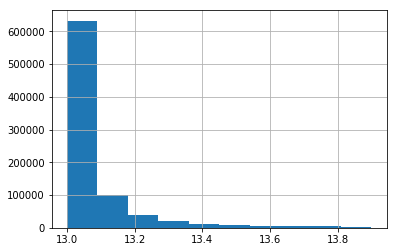

In [143]:
merge_table_df['score'].hist()

### Filter internal edges (according to master node)

In [144]:
master_merge_table_df = merge_table_df.copy()
master_merge_table_df['body_a'] = master_mapper.apply(master_merge_table_df['id_a'].values, True)
master_merge_table_df['body_b'] = master_mapper.apply(master_merge_table_df['id_b'].values, True)

## Drop uncorrected splits
orig_len = len(master_merge_table_df)
master_merge_table_df.query('body_a != 0 and body_b != 0', inplace=True)
new_len = len(master_merge_table_df)
print(f"Dropped {orig_len - new_len} split edges, kept {new_len}")

orig_len = len(master_merge_table_df)
master_merge_table_df.query('body_a != body_b', inplace=True)
new_len = len(master_merge_table_df)
print(f"Dropped {orig_len - new_len} internal edges, kept {new_len}")

Dropped 40 split edges, kept 834544
Dropped 38177 internal edges, kept 796367


### Drop all previously reviewed

In [145]:
# unreviewed_it2_twohop_df = drop_previously_reviewed(master_merge_table_df, previous_focused_decisions)
# num_twohop_edges = len(unreviewed_it2_twohop_df)
# num_twohop_bodies = len(pd.unique(unreviewed_it2_twohop_df[['body_a', 'body_b']].values.reshape(-1)))
# print(f"Found {num_twohop_edges / 1e6:.2f}M edges, touching {num_twohop_bodies/1e6:.2f}M bodies")

Found 0.79M edges, touching 0.73M bodies


#### How many are 1-hop edges that we've missed so far?

In [133]:
# # (we missed these due to previously incomplete focused list)
# it2_onehop_df = unreviewed_it2_twohop_df.query('body_a in @important_bodies and body_b in @important_bodies')
# print(f"Found {len(it2_onehop_df)} new 1-hop edges")
# it2_onehop_df.to_csv('it2-onehop.csv', header=True, index=False)

Found 11861 new 1-hop edges


#### it2 one-hop assignments

In [173]:
it2_onehop_df = load_focused_table('it2-onehop.csv')
it2_onehop_df.shape

(11861, 13)

In [174]:
it2_onehop_df.sort_values('score', inplace=True)
it2_onehop_df = drop_unordered_duplicates(it2_onehop_df, ['body_a', 'body_b'])
it2_onehop_df.shape

(11031, 13)

In [176]:
np.random.seed(0)
shuffled_index = np.array(it2_onehop_df.index)
np.random.shuffle(shuffled_index)
shuffled_it2_onehop_df = it2_onehop_df.loc[shuffled_index]

In [178]:
generate_assignments(shuffled_it2_onehop_df, 5000, 'it2-onehop-assignments')

100%|██████████| 11/11 [00:00<00:00, 31.93it/s]


#### (it1 only)

In [146]:
unreviewed_it1_twohop_df = drop_previously_reviewed(master_merge_table_df, previous_focused_decisions)
num_twohop_edges = len(unreviewed_it1_twohop_df)
num_twohop_bodies = len(pd.unique(unreviewed_it1_twohop_df[['body_a', 'body_b']].values.reshape(-1)))
print(f"Found {num_twohop_edges / 1e6:.2f}M edges, touching {num_twohop_bodies/1e6:.2f}M bodies")

Found 0.79M edges, touching 0.73M bodies


### Append body sizes

In [125]:
unreviewed_it2_twohop_df.drop(columns=['voxel_count_a', 'voxel_count_b'], errors='ignore')
unreviewed_it2_twohop_df = unreviewed_it2_twohop_df.merge(
                                master_body_stats[['voxel_count']],
                                how='left', left_on='body_a', right_index=True)
unreviewed_it2_twohop_df = unreviewed_it2_twohop_df.merge(
                                master_body_stats[['voxel_count']],
                                how='left', left_on='body_b', right_index=True,
                                suffixes=['_a', '_b'])

In [150]:
unreviewed_it1_twohop_df[['body_a', 'body_b']].duplicated().sum()

382881

In [148]:
_tmp = np.sort(unreviewed_it1_twohop_df[['body_a', 'body_b']].values, axis=1)
pd.DataFrame(_tmp).duplicated().sum()

385201